# Forecasting Sales of `TOTAL UNIVERSE (Supermarkets + Hypermarkets)` with the Holt-Winters Method

In [1]:
# dataframe opertations
import pandas as pd
import numpy as np
# plotting data - matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#evaluation metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

#Ignore the warning, can comment this 
import warnings
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

pd.options.display.float_format = '{:,}'.format
pd.options.display.float_format = "{:,.2f}".format

# Note
> Each store-week combination has got a `projection factor` which explains the number of stores that store-week is representative of within the Universe.

# Preparing the data

In [56]:
# Import the data
data = pd.read_csv("data.csv", index_col=[0])

#checking column names
data.columns

Index(['store_code', 'week_code', 'prod_code', 'units_sold', 'sales_(€)',
       'sales_volume_(lt)', 'real_unit_price', 'real_volume_price',
       'rate_price_in_units', 'rate_price_in_volume', 'promotion_aisle_promo',
       'promotion_brochure_promo', 'promotion_discount_promo',
       'promotion_display_promo', 'promotion_extra_quantity_promo',
       'promotion_gift_promo', 'promotion_multipurchase_promo',
       'promotion_shelf_header_promo', 'projection_factor', 'canal_code',
       'province_code', 'postal_code', 'sales_surface_sqmeters', 'date',
       'segment', 'manufacturer', 'brand', 'packaging', 'volume_(ml)',
       'units_(ct)', 'province', 'autonomous_community', 'min_temp',
       'max_temp', 'avg_temp', 'precipitation_(mm)'],
      dtype='object')

In [148]:
#selecting columns to work with
projections = data[['date','store_code', 'sales_(€)', 'projection_factor']]

#date to datetime object
data['date'] = pd.to_datetime(data['date'])

#checking output
projections.head()

,date,store_code,sales_(€),projection_factor
0,2020-10-18,243,19.50,11.48
1,2020-10-18,243,1.82,11.48
2,2020-10-18,243,10.32,11.48
3,2020-10-18,243,14.97,11.48
4,2020-10-18,243,10.88,11.48


In [149]:
#grouping by date, store code and projection factor
#this way we can identify  the projection factor corresponding to each store+date combination

projections = projections.groupby(['date', 'store_code', 'projection_factor'])['sales_(€)'].sum().to_frame()

#checking output
projections.head()

sales_(€)
date       store_code projection_factor           
2020-01-05 1          54.85               1,888.61
           3          67.68               1,284.54
           4          2.20                4,597.96
           5          20.97               1,097.98
           7          62.27                 313.23

In [150]:
#reset index to make operations possible between columns
projections = projections.reset_index()

#creating new column to store the result from projection_factor * sales_(€)
projections['total_universe_sales'] = projections['sales_(€)'] * projections['projection_factor']

#checking output
projections.head()

,date,store_code,projection_factor,sales_(€),total_universe_sales
0,2020-01-05,1,54.85,"1,888.61","103,590.26"
1,2020-01-05,3,67.68,"1,284.54","86,937.67"
2,2020-01-05,4,2.20,"4,597.96","10,115.51"
3,2020-01-05,5,20.97,"1,097.98","23,024.64"
4,2020-01-05,7,62.27,313.23,"19,504.83"


In [151]:
projections_final = projections.groupby(['date'])['total_universe_sales'].sum().to_frame()

print(f'Shape of final df: {projections_final.shape}')

projections_final.head()

Shape of final df: (120, 1)


,total_universe_sales
date,
2020-01-05,"22,998,460.84"
2020-01-12,"21,900,666.44"
2020-01-19,"22,044,668.93"
2020-01-26,"21,830,116.38"
2020-02-02,"23,579,391.62"


In [152]:
#checking data types before moving formward
projections_final.dtypes

total_universe_sales    float64
dtype: object

In [153]:
projections_final.reset_index(inplace=True) #reset index

#date to datetime object
projections_final['date'] = pd.to_datetime(projections_final['date'])

projections_final=projections_final.set_index('date')

#final df must have 120 weeks of data rocorded
projections_final.shape

(120, 1)

In [154]:
projections_final.head()

,total_universe_sales
date,
2020-01-05,"22,998,460.84"
2020-01-12,"21,900,666.44"
2020-01-19,"22,044,668.93"
2020-01-26,"21,830,116.38"
2020-02-02,"23,579,391.62"


In [156]:
#assign final df to variable name previously used to fit the models
df = projections_final.copy()

## Visualizing the data

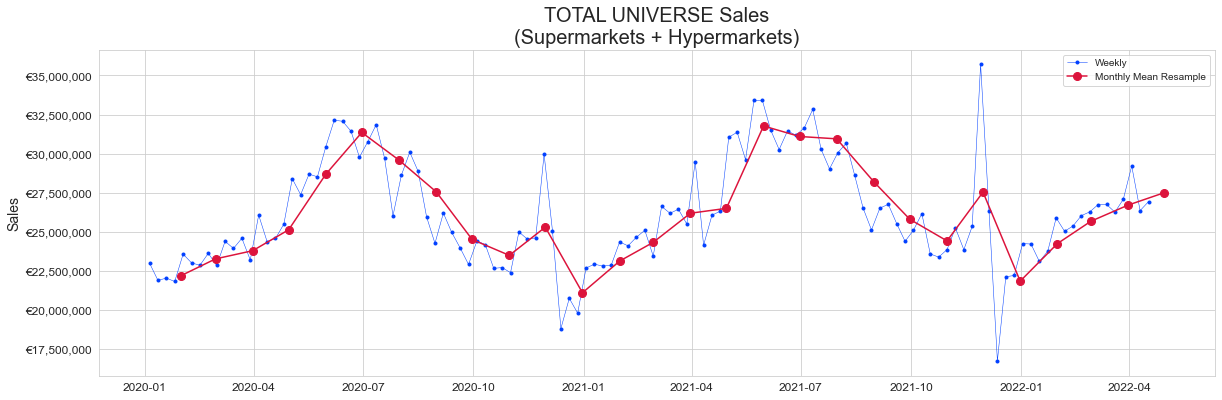

In [68]:
import seaborn as sns
sns.set_style("whitegrid")

import warnings
import matplotlib.pyplot as plt
y = df['total_universe_sales']

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', 
        markersize=8, linestyle='-', 
        label='Monthly Mean Resample', 
        color='crimson')

plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.set_title("TOTAL UNIVERSE Sales\n(Supermarkets + Hypermarkets)", fontsize=20)
ax.set_ylabel('Sales')
ax.legend();

## Decomposing the Data

In [73]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='mul',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

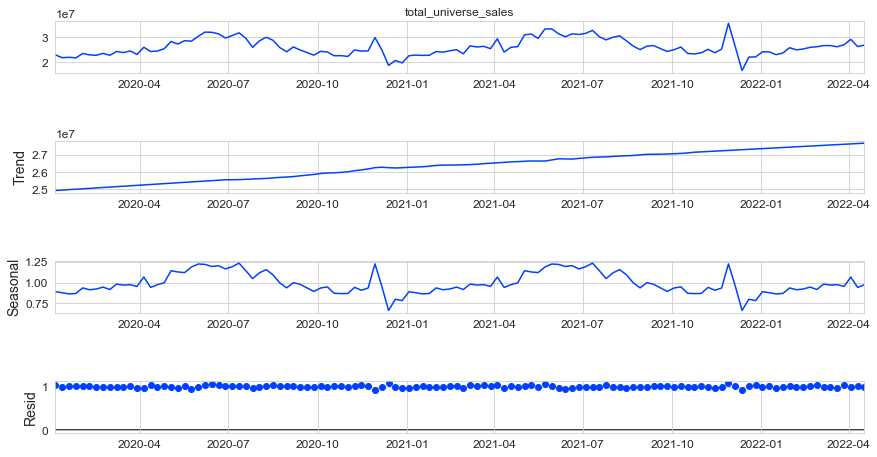

In [74]:
seasonal_decompose(y)

# Single HWES

In [75]:
# Set the frequency of the date time index as Monthly start as indicated by the data
df.index.freq = "W"

# Set the value of Alpha and define m (Time Period)
m = 52
alpha = 1/(2*m)

#fitting the model
df['HWES1'] = SimpleExpSmoothing(df['total_universe_sales']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues

MAPE% on fitted values HW Single Exp Smoothing = 10.1%


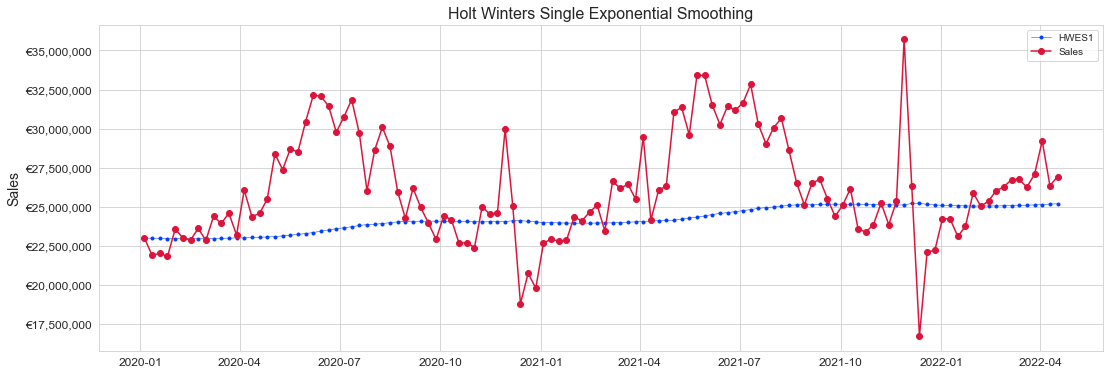

In [77]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES1'],marker='.', linestyle='-', linewidth=0.5, label='HWES1')
ax.plot(df['total_universe_sales'],marker='o', markersize=6, linestyle='-', label='Sales', color='crimson')
ax.set_title(f"Holt Winters Single Exponential Smoothing", fontsize=16)
ax.set_ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.legend();

#evaluation metric
mape_HWES1 = round(mean_absolute_percentage_error(df['total_universe_sales'],df['HWES1'])*100, 2)

#printing evaluation metric
print(f'MAPE% on fitted values HW Single Exp Smoothing = {mape_HWES1}%')

## Observations
As expected, it didn’t fit quite well, and rightfully so, because if we remember, Single ES doesn’t work for data with Trends and Seasonality. 

# Double HWES

In [80]:
df['HWES2_ADD'] = ExponentialSmoothing(df['total_universe_sales'],trend='add').fit().fittedvalues

df['HWES2_MUL'] = ExponentialSmoothing(df['total_universe_sales'],trend='mul').fit().fittedvalues

df[['total_universe_sales','HWES2_ADD','HWES2_MUL']]

,total_universe_sales,HWES2_ADD,HWES2_MUL
date,,,
2020-01-05,"22,998,460.84","21,924,875.84","22,101,530.75"
2020-01-12,"21,900,666.44","22,516,884.85","22,786,698.07"
2020-01-19,"22,044,668.93","22,182,866.99","22,485,385.46"
2020-01-26,"21,830,116.38","22,110,650.22","22,423,004.49"
2020-02-02,"23,579,391.62","21,960,316.48","22,270,505.56"
...,...,...,...
2022-03-20,"26,260,841.48","26,609,553.30","26,744,172.87"
2022-03-27,"27,087,598.81","26,425,279.41","26,559,030.73"
2022-04-03,"29,212,648.73","26,795,208.00","26,933,821.26"


MAPE% for fitted values HWS2_ADD = 5.78%
MAPE% for fitted values HWS2_MUL = 5.81%


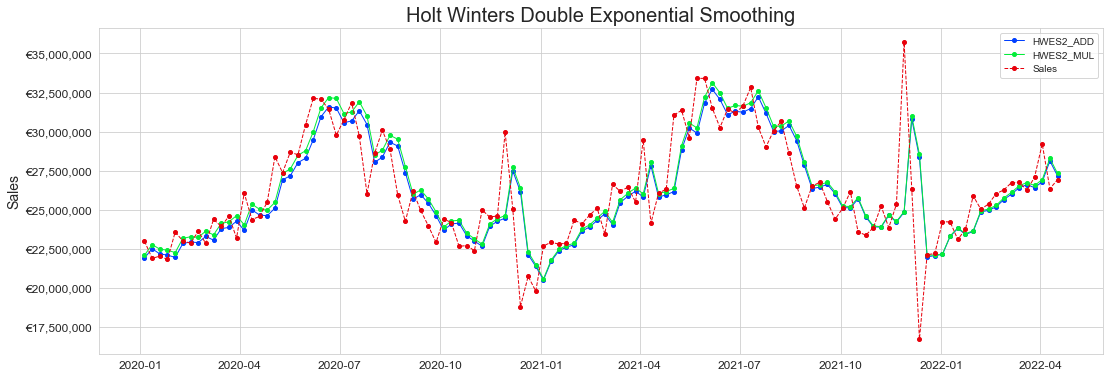

In [81]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES2_ADD'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES2_ADD')
ax.plot(df['HWES2_MUL'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES2_MUL')
ax.plot(df['total_universe_sales'],marker='o', markersize=4, linestyle='--', linewidth=1, label='Sales')
ax.set_title("Holt Winters Double Exponential Smoothing", fontsize=20)
ax.set_ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.legend();

#evaluation metrics
mape_HWS2_ADD = round(mean_absolute_percentage_error(df['total_universe_sales'],df['HWES2_ADD'])*100, 2)
mape_HWS2_MUL = round(mean_absolute_percentage_error(df['total_universe_sales'],df['HWES2_MUL'])*100, 2)

#printing evaluation metrics        
print(f'MAPE% for fitted values HWS2_ADD = {mape_HWS2_ADD}%')
print(f'MAPE% for fitted values HWS2_MUL = {mape_HWS2_MUL}%')

### Observations
Well, this looks a little better, but since we know there is Seasonality, we shall move into Triple ES and look at how it fits.

# Triple HWES

In [123]:
#Triple HWES helps us include a seasonal periods
#the seasonal parameter for out data is s=52 (the one attributed to data with weekly seasonality)

df['HWES3_ADD'] = ExponentialSmoothing(df['total_universe_sales'], trend='add',seasonal='add',seasonal_periods=52).fit().fittedvalues

df['HWES3_MUL'] = ExponentialSmoothing(df['total_universe_sales'], trend='mul',seasonal='mul',seasonal_periods=52).fit().fittedvalues

df[['HWES3_ADD', 'HWES3_MUL', 'total_universe_sales']]

,HWES3_ADD,HWES3_MUL,total_universe_sales
date,,,
2020-01-05,"21,903,549.69","22,015,606.75","22,998,460.84"
2020-01-12,"22,196,403.86","22,297,114.93","21,900,666.44"
2020-01-19,"22,064,096.07","22,163,921.72","22,044,668.93"
2020-01-26,"22,118,269.89","22,214,752.29","21,830,116.38"
2020-02-02,"23,564,712.83","23,616,261.62","23,579,391.62"
...,...,...,...
2022-03-20,"27,449,783.64","27,526,002.79","26,260,841.48"
2022-03-27,"26,411,571.65","26,438,695.80","27,087,598.81"
2022-04-03,"30,310,464.81","30,515,019.13","29,212,648.73"


MAPE% for fitted values HWS3_ADD = 2.19%
MAPE% for ftted values HWS3_MUL = 2.21%


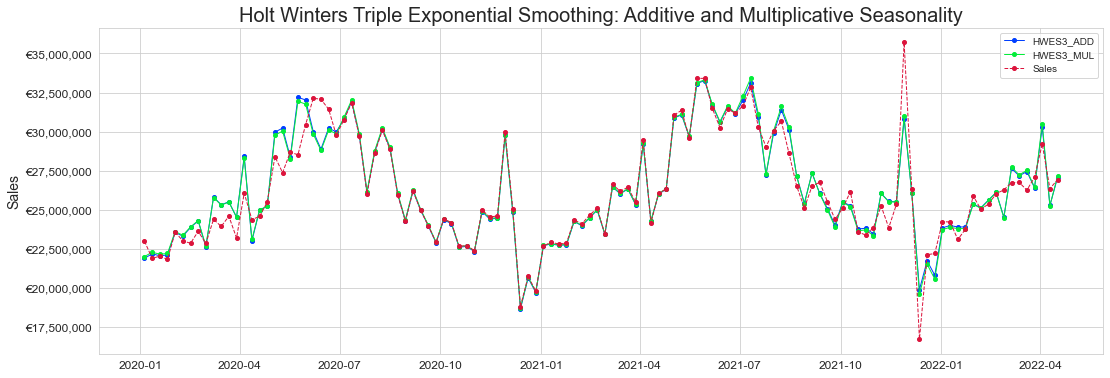

In [124]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES3_ADD'],marker='o' ,markersize=4, linestyle='-', linewidth=1, label='HWES3_ADD')
ax.plot(df['HWES3_MUL'], marker='o', markersize=4, linestyle='-', linewidth=1, label='HWES3_MUL')
ax.plot(df['total_universe_sales'],marker='o', markersize=4, linestyle='--', linewidth=1, label='Sales', color='crimson')
ax.set_title("Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality", fontsize=20)
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.set_ylabel('Sales')

ax.legend();

#evaluation metrics
mape_HWS3_ADD = round(mean_absolute_percentage_error(df['total_universe_sales'],df['HWES3_ADD'])*100, 2)
mape_HWS3_MUL = round(mean_absolute_percentage_error(df['total_universe_sales'],df['HWES3_MUL'])*100, 2)

#printing evaluation metrics        
print(f'MAPE% for fitted values HWS3_ADD = {mape_HWS3_ADD}%')
print(f'MAPE% for ftted values HWS3_MUL = {mape_HWS3_MUL}%')

# Splitting into Train & Test Set
Why are we sticking with HW Triple Exponential Smoothing?
Because according to the diagnostic plots made in the beginning we know there is Seasonality and a Trend and the MAPE% on fitted values for the `HW Triple ES` indicate the lowest proprotion of error, therefore, this model is the best option for us. 

In [98]:
#checking final df to assure we are dealing with the desired data points
print(projections_final.shape)

projections_final.head()

(120, 1)


,total_universe_sales
date,
2020-01-05,"22,998,460.84"
2020-01-12,"21,900,666.44"
2020-01-19,"22,044,668.93"
2020-01-26,"21,830,116.38"
2020-02-02,"23,579,391.62"


In [99]:
#keeping variables name 
forecast_data = projections_final.copy()

In [100]:
#checking output
forecast_data.head()

,total_universe_sales
date,
2020-01-05,"22,998,460.84"
2020-01-12,"21,900,666.44"
2020-01-19,"22,044,668.93"
2020-01-26,"21,830,116.38"
2020-02-02,"23,579,391.62"


In [101]:
#final df must have 120 rows of recorded data
forecast_data.shape

(120, 1)

In [102]:
#Let's split our data with the traditional 80/20 split
#Since we are dealing with time series data the order to the records must be kept intact

train = forecast_data[:105]  # taking 105 data points as train-set (2+ years in weekly sales format)
test = forecast_data[105:] # taking the last 15 data points as test-set 

In [103]:
#checking dates for train-set
print(train.index.min())
print(train.index.max())

2020-01-05 00:00:00
2022-01-02 00:00:00


In [104]:
#checking dates for test-set
print(test.index.min())
print(test.index.max())

2022-01-09 00:00:00
2022-04-17 00:00:00


In [105]:
#shapes must be 105 and 15 respectively
print(train.shape)
print(test.shape)

(105, 1)
(15, 1)


# Fitting the Models to the train data & making forecasts

In [106]:
#creating an empty container to score model evaluation metrics
model_metrics = []

In [113]:
#defining a function to change parameters easily and do a trial and error procedure
def HW_model(trend, seasonal, seasonal_periods, damped, title):
    
    fitted_model = ExponentialSmoothing(train['total_universe_sales'],
                                    trend=trend,
                                    seasonal=seasonal,
                                    seasonal_periods=seasonal_periods,
                                    use_boxcox=True,
                                    damped=damped, 
                                    initialization_method="estimated").fit()

    test_predictions = fitted_model.forecast(15) 
    title=title
    
    #plotting
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(train['total_universe_sales'],marker='o',markersize=4, linestyle='-', linewidth=1, label='Train')
    ax.plot(test['total_universe_sales'],marker='o',markersize=4, linestyle='-', linewidth=1, label='Test', color='limegreen')
    ax.plot(test_predictions, marker='o', markersize=4, linestyle='-', linewidth=1, label='Prediction', color='crimson')
    ax.set_title(f'{title}\nTrain, Test and Predicted Values\n Holt-Winters ({trend}-{seasonal}-seasonal-damped={damped})', fontsize=16)
    ax.set_ylabel('Sales')
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))  
    ax.legend()
    plt.show()

    #zooming into test vs predicted
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(test['total_universe_sales'], marker='o', markersize=5, linestyle='-', linewidth=1, label='Test', color='limegreen')
    ax.plot(test_predictions, marker='o', markersize=5, linestyle='-', linewidth=1, label='Prediction', color='crimson')
    ax.set_title('Zooming in', fontsize=16)
    ax.set_ylabel('Sales')
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))  
    ax.legend()
    plt.show()

    #saving metrics in variables
    mae = mean_absolute_error(test,test_predictions)
    mse = mean_squared_error(test,test_predictions)
    mape = round(mean_absolute_percentage_error(test,test_predictions)*100, 2)
    rmse = mean_squared_error(test,test_predictions, squared=False)
    
    #printing evaluation metrics        
    print(f'Mean Absolute Error = {mae}')
    print(f'Mean Squared Error = {mse}')
    print(f'MAPE% = {mape}%')
    print(f'RMSE = {rmse}')

    #saving metrics for later comparison
    model_metrics.append({
            "model" : f'HW ({trend}-{seasonal}-seasonal-damped={damped})',
            "MAE" : mae,
            "MSE": mse, 
            "MAPE": f'{mape}%', 
            "RMSE": f'{rmse}'
    })

## Holt-Winters (mul-mul-seasonal)

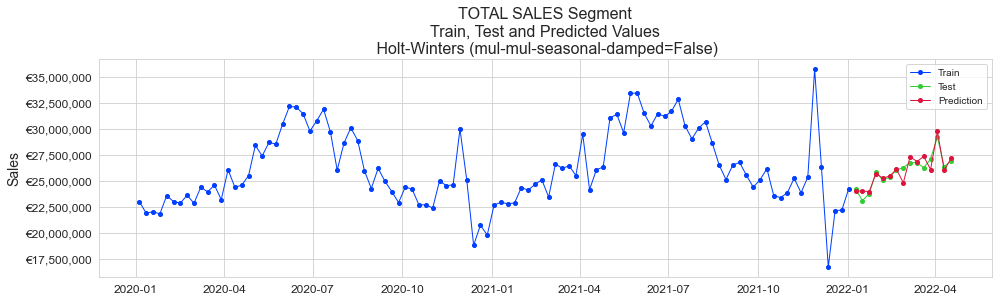

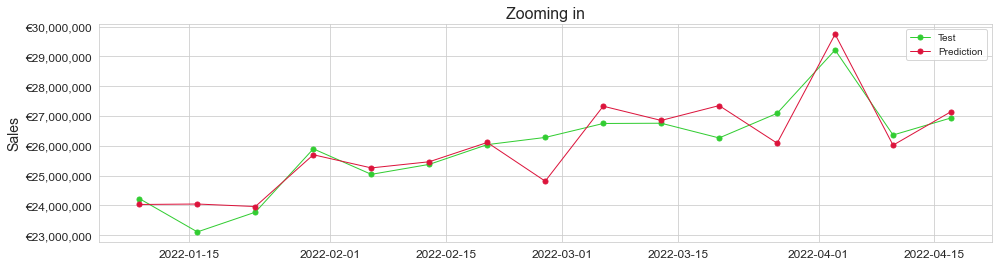

Mean Absolute Error = 480616.2177694442
Mean Squared Error = 411634626473.5686
MAPE% = 1.85%
RMSE = 641587.5828548808


In [114]:
HW_model('mul', 'mul', 52, False, "TOTAL SALES Segment")

## Holt-Winters (add-add-seasonal)

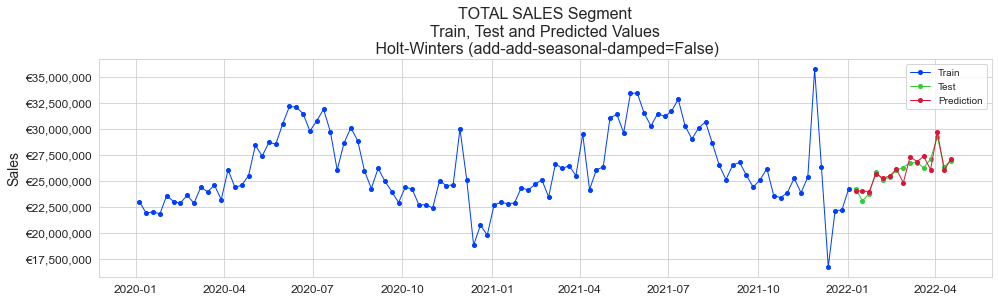

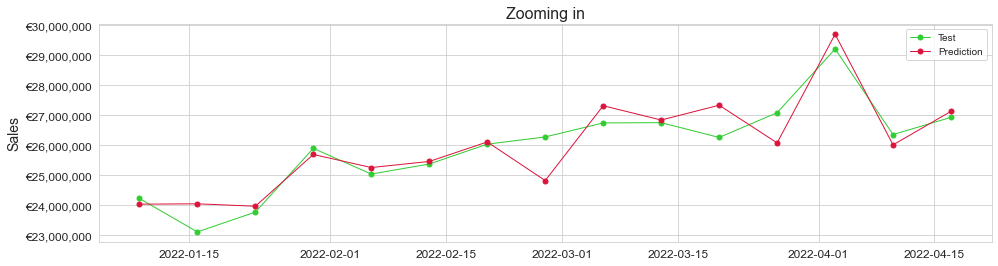

Mean Absolute Error = 476524.5779156891
Mean Squared Error = 406209723596.53973
MAPE% = 1.84%
RMSE = 637345.8430056163


In [115]:
HW_model('add', 'add', 52, False, "TOTAL SALES Segment")

## Holt-Winters (add-add-seasonal-damped)

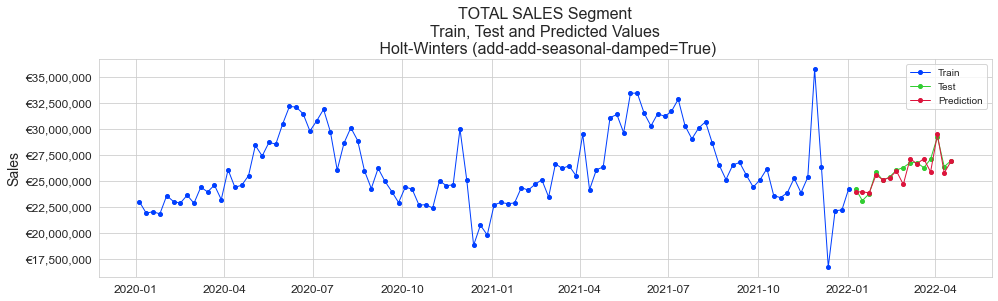

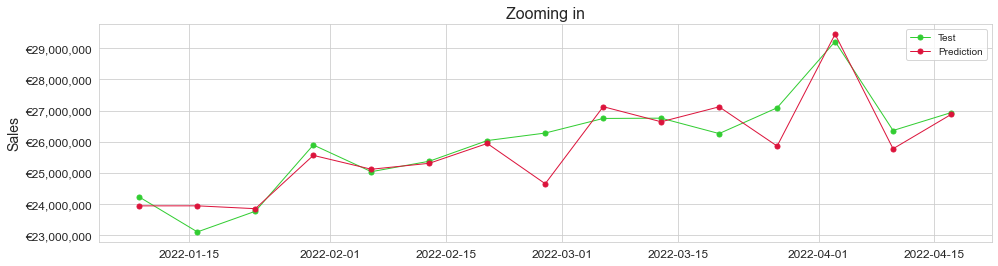

Mean Absolute Error = 456886.8473598989
Mean Squared Error = 423824338033.93854
MAPE% = 1.76%
RMSE = 651017.9245104842


In [116]:
HW_model('add', 'add', 52, True, 'TOTAL SALES Segment')

## Holt-Winters (add-mul-seasonal)

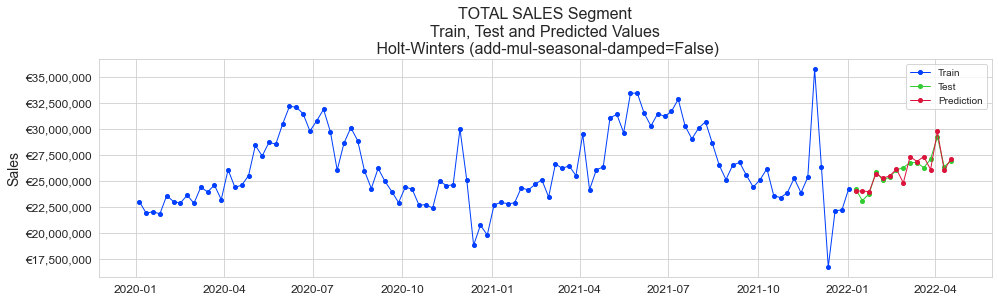

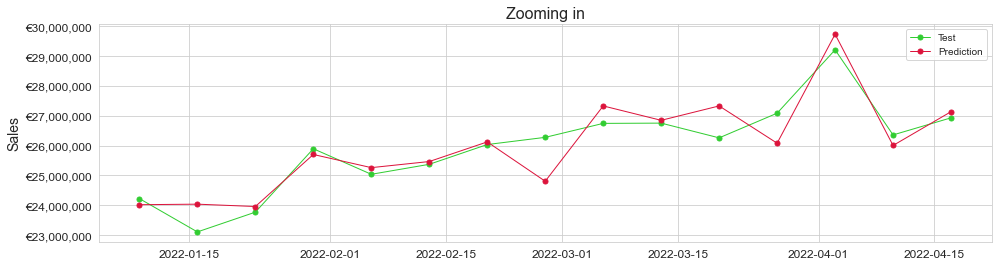

Mean Absolute Error = 482077.3468449836
Mean Squared Error = 410852050427.8303
MAPE% = 1.86%
RMSE = 640977.4180326717


In [117]:
HW_model('add', 'mul', 52, False, 'TOTAL SALES Segment')

## Holt-Winters (add-mul-seasonal-damped)

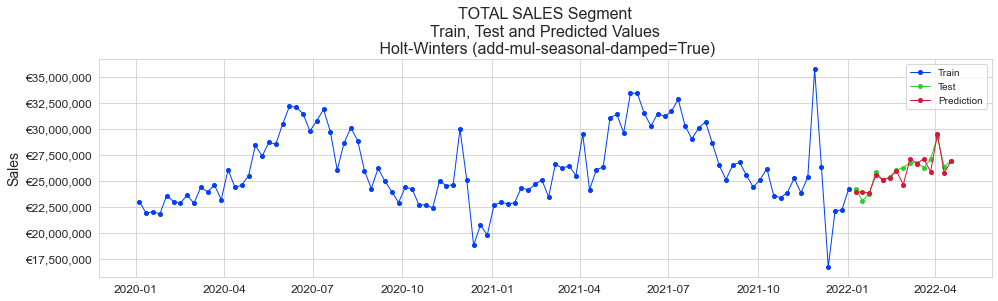

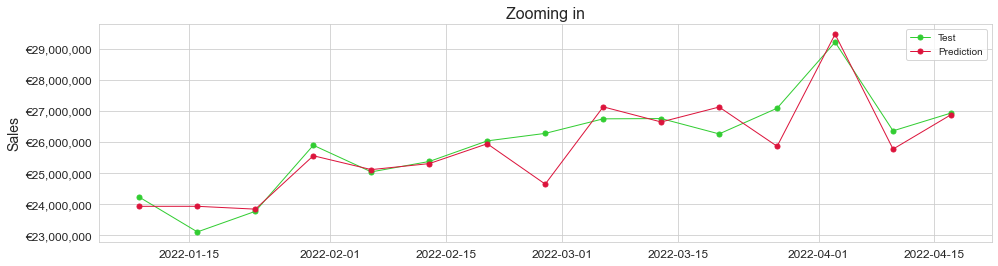

Mean Absolute Error = 458195.03204238415
Mean Squared Error = 426013893463.3631
MAPE% = 1.76%
RMSE = 652697.3980822683


In [118]:
HW_model('add', 'mul', 52, True, "TOTAL SALES Segment")

# Model Comparison

In [119]:
model_metrics
model_metrics_df = pd.DataFrame(model_metrics, 
                                columns = ["model", 
                                           'MSE',
                                           'MAE', 
                                           "MAPE", 
                                           "RMSE"]).set_index("model").sort_values(by=["RMSE"], ascending=True)
model_metrics_df  

,MSE,MAE,MAPE,RMSE
model,,,,
HW (add-add-seasonal-damped=False),"406,209,723,596.54","476,524.58",1.84%,637345.8430056163
HW (add-mul-seasonal-damped=False),"410,852,050,427.83","482,077.35",1.86%,640977.4180326717
HW (mul-mul-seasonal-damped=False),"411,634,626,473.57","480,616.22",1.85%,641587.5828548808
HW (add-add-seasonal-damped=True),"423,824,338,033.94","456,886.85",1.76%,651017.9245104842
HW (add-mul-seasonal-damped=True),"426,013,893,463.36","458,195.03",1.76%,652697.3980822683


## About the evaluation metrics
* We previously establsihed that the `MAPE%` was going to be our first reference in model selection, but in this case we have very similar `MAPE%` metrics across the board so we must make the decision based on the `RMSE`

# Forecasting

In [130]:
#defining a function to make forecasts in any range of steps ahead
def final_HW_model(trend, seasonal, seasonal_periods, damped, steps_ahead, title):
    
    #defining variables to describe parameters and specifics of the model and timeframes
    trend = trend
    seasonal = seasonal
    seasonal_periods = seasonal_periods
    damped = damped
    
    #fitting the model
    fit = ExponentialSmoothing(forecast_data,
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods, 
                            damped=damped,
                            use_boxcox=True, 
                            initialization_method="estimated").fit()
    
    simulations = fit.simulate(steps_ahead, repetitions=100, error='add')
    
    ax = forecast_data.plot(figsize=(18, 6), marker="o", markersize=4, lw=1)
    ax.set_title(f"Forecast and Simulation for {title}\nHolt-Winters ({trend}-{seasonal}-seasonal-damped={damped})", fontsize=18)
    ax.set_ylabel("Sales")
    ax.set_xlabel(" ")
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))
           
    fit.fittedvalues.plot(ax=ax, style="--", markersize=3, color="crimson", label='Fitted Values',  legend=True)
    simulations.plot(ax=ax, style="-", alpha=0.05, color="orange", legend=False)
    fit.forecast(steps_ahead).rename(f"Train, Test and Predicted Test\nHolt-Winters ({trend}-{seasonal}-seasonal-damped={damped})").plot(
    ax=ax, style="-", marker="o", markersize=4,  color="crimson", lw=1, legend=True, label='Predictions')
    
    # Annotate
    x_line_annotation = '2022-4-1'
    x_text_annotation = '2022-4-1'
    ax.axvline(x=x_line_annotation, linestyle='dashed', color='b')
    ax.text(x=x_text_annotation, y=38000000, s='2022Q2', color='b')
    
    x_line_annotation = '2022-07-1'
    x_text_annotation = '2022-07-1'
    ax.axvline(x=x_line_annotation, linestyle='dashed', color='g')
    ax.text(x=x_text_annotation, y=38000000, s='2022Q3', color='g')

    x_line_annotation = '2022-10-1'
    x_text_annotation = '2022-10-1'
    ax.axvline(x=x_line_annotation, linestyle='dashed', color='r')
    ax.text(x=x_text_annotation, y=38000000, s='2022Q4', color='r')
    plt.axvline(x='2022-12-31', color='r', linestyle='dashed')
    
    x_line_annotation = '2023-01-01'
    x_text_annotation = '2023-01-01'
    ax.axvline(x=x_line_annotation, linestyle='dashed', color='orangered')
    ax.text(x=x_text_annotation, y=38000000, s='FY-2023', color='orangered')
    plt.axvline(x='2023-12-31', color='orangered', linestyle='dashed')
    
    #plt.ylim(0,4000000)
    
    return plt.show()

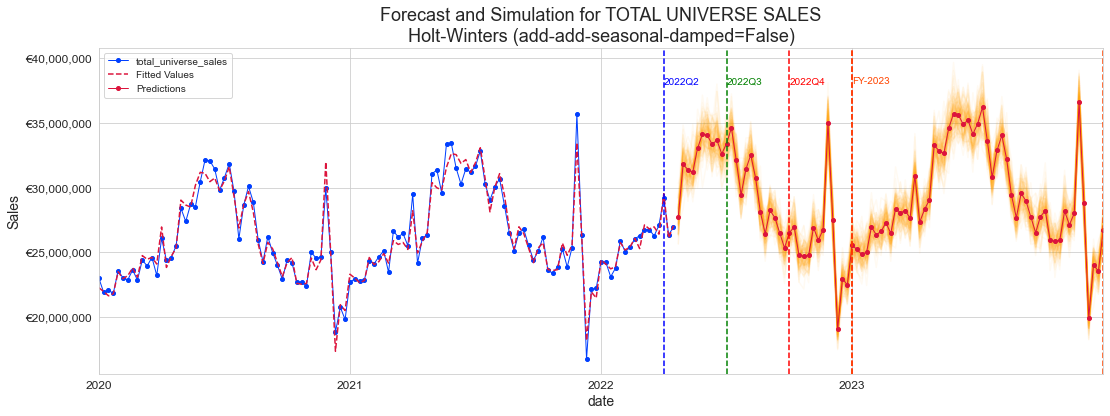

In [131]:
#why are we chooing 89 steps ahead?
    #because those the total steps ahead necessary to do the forecast until the end of FY-2023
final_HW_model('add', 'add', 52, False, 89, 'TOTAL UNIVERSE SALES') 

## Defining Function to obtain either `Yearly` or `Quarterly` data with both historical and forecasted sales

In [199]:
#Preparing the data
historical_data = projections_final.copy()

historical_data

,total_universe_sales
date,
2020-01-05,"22,998,460.84"
2020-01-12,"21,900,666.44"
2020-01-19,"22,044,668.93"
2020-01-26,"21,830,116.38"
2020-02-02,"23,579,391.62"
...,...
2022-03-20,"26,260,841.48"
2022-03-27,"27,087,598.81"
2022-04-03,"29,212,648.73"


In [200]:
#fitting data to best performing model
fit = ExponentialSmoothing(historical_data,
                            trend='add',
                            seasonal='add',
                            seasonal_periods=52, 
                            damped=False,
                            use_boxcox=False, 
                            initialization_method="estimated").fit()

#making the forecast and putting values in inside a dataframe
forecast = fit.forecast(89).to_frame().reset_index()

forecast.head()

,index,0
0,2022-04-24,"27,394,413.96"
1,2022-05-01,"31,952,492.23"
2,2022-05-08,"32,153,646.74"
3,2022-05-15,"30,709,448.85"
4,2022-05-22,"34,150,110.80"


In [201]:
#formatting forecasted data points
forecast.rename(columns={0: 'total_universe_sales', 'index': 'date'} ,inplace=True)

#checking output
forecast.head()

,date,total_universe_sales
0,2022-04-24,"27,394,413.96"
1,2022-05-01,"31,952,492.23"
2,2022-05-08,"32,153,646.74"
3,2022-05-15,"30,709,448.85"
4,2022-05-22,"34,150,110.80"


In [202]:
forecast.dtypes

date                    datetime64[ns]
total_universe_sales           float64
dtype: object

In [203]:
#convert date column to datetime object
forecast['date'] = pd.to_datetime(forecast['date'])

#group by quarterly total sales
forecast = forecast.groupby(forecast['date'].dt.to_period('Q'))['total_universe_sales'].sum().to_frame()

#formatting to concatenate
forecast = forecast.reset_index()

#we signal to the original df and group by quarterly historical sales
historical_data = historical_data.reset_index()

historical_data = historical_data.groupby(historical_data['date'].dt.to_period('Q'))['total_universe_sales'].sum().to_frame()

historical_data = historical_data.reset_index()

#concatenating
dfs = [historical_data, forecast]
historical_with_forecast = pd.concat(dfs, ignore_index=False)

In [204]:
#grouping by week to get total weekly sales
quarterly = historical_with_forecast.groupby(['date'])['total_universe_sales'].sum().to_frame()

quarterly

,total_universe_sales
date,
2020Q1,"300,854,522.36"
2020Q2,"369,392,350.19"
2020Q3,"354,220,171.08"
2020Q4,"304,942,836.45"
2021Q1,"317,766,580.28"
2021Q2,"389,250,980.23"
2021Q3,"367,985,881.61"
2021Q4,"319,688,459.38"
2022Q1,"330,822,913.96"


In [205]:
#calculating percent change in quarterly sales
pct_change_q = quarterly.pct_change()

pct_change_q.rename(columns = {'total_universe_sales':'quarterly_pct_change'}, inplace = True)

#converting to percentage
pct_change_q['quarterly_pct_change'] = pct_change_q['quarterly_pct_change']*100

pct_change_q

,quarterly_pct_change
date,
2020Q1,NaN
2020Q2,22.78
2020Q3,-4.11
2020Q4,-13.91
2021Q1,4.21
2021Q2,22.50
2021Q3,-5.46
2021Q4,-13.12
2022Q1,3.48
